<a href="https://colab.research.google.com/github/onlygoodman/dacon_shopping_reviewscore_predict/blob/main/project_shop_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

001 - https://wikidocs.net/94600 네이버 쇼핑 리뷰 데이터 분석을 참조하여 0,1 긍부정 이진 분류를 통해 확률을 0~5로 확장하여 예측


002 - 001 코드에서 target 그대로 활용, 다중분류로 예측 시도


In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 27.10 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 120.4 MB/s 
     |████████████████████████████████| 453 kB 60.3 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-07-14 01:19:37--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org 

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Train dataset은 Label이 존재하지 않음
train_data = pd.read_csv("/content/drive/MyDrive/shopping_dataset/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/shopping_dataset/test.csv")
submit = pd.read_csv("/content/drive/MyDrive/shopping_dataset/sample_submission.csv")

In [ ]:
train_data.head(10)
train_data['target'].unique()

array([2, 1, 5, 4])

In [ ]:
def predata(data):
  data['label'] = np.select([data.target > 3], [1], default = 0)

  #혹시 중복이 있다면 제거
  data.drop_duplicates(subset=['reviews'], inplace=True)

In [ ]:
predata(train_data)

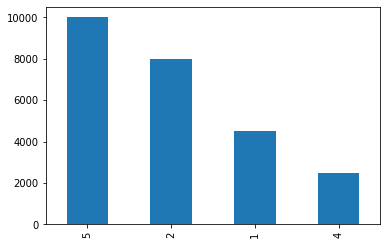

In [ ]:
train_data['target'].value_counts().plot(kind='bar')

In [ ]:
print(train_data.groupby('target').size().reset_index(name = 'count'))

   target  count
0       1   4500
1       2   8000
2       4   2500
3       5  10000


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id         0
reviews    0
target     0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
# test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
# test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
# test_data = test_data.dropna(how='any') # Null 값 제거
# print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 25000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
# test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 5239), ('안', 3373), ('는데', 3360), ('어요', 2567), ('있', 2222), ('너무', 2156), ('했', 1969), ('배송', 1620), ('좋', 1620), ('구매', 1551), ('거', 1511), ('같', 1478), ('없', 1470), ('어', 1441), ('되', 1434), ('아요', 1430), ('잘', 1373), ('그냥', 1373), ('습니다', 1354), ('않', 1278)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 6529), ('아요', 3513), ('네요', 3291), ('잘', 3188), ('어요', 3090), ('구매', 2666), ('습니다', 2310), ('있', 2145), ('배송', 1992), ('는데', 1957), ('먹', 1625), ('합니다', 1588), ('했', 1567), ('재', 1529), ('너무', 1434), ('같', 1365), ('만족', 1206), ('쓰', 1132), ('거', 1079), ('기', 1070)]


평점 : 1점의 평균 길이 : 17.972870802757395
평점 : 2점의 평균 길이 : 16.729821048679764
평점 : 3점의 평균 길이 : nan
평점 : 4점의 평균 길이 : 14.6032
평점 : 5점의 평균 길이 : 13.474226804123711


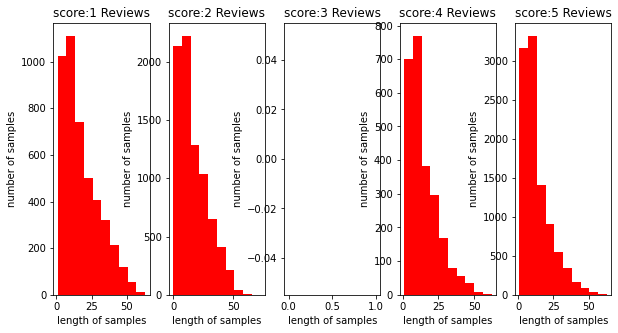

In [ ]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(10,5))

axlist=[0,ax1,ax2,ax3,ax4,ax5]

for i in range(1, 6):
  text_len = train_data[train_data['target']==i]['tokenized'].map(lambda x: len(x))
  axlist[i].hist(text_len, color='red')
  axlist[i].set_title('score:{} Reviews'.format(i))
  axlist[i].set_xlabel('length of samples')
  axlist[i].set_ylabel('number of samples')
  print('평점 : {}점의 평균 길이 :'.format(i), np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
train_data1 = pd.get_dummies(train_data['target'])

In [ ]:
y_train = train_data1.values
y_train

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
y_train.shape

(24979, 4)

In [ ]:
#정수인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17534
등장 빈도가 1번 이하인 희귀 단어의 수: 8171
단어 집합에서 희귀 단어의 비율: 46.60088970001141
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1188099813038552


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9365


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24979 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         24979 non-null  int64 
 1   reviews    24979 non-null  object
 2   target     24979 non-null  int64 
 3   tokenized  24979 non-null  object
 4   label      24979 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[359, 22, 152, 120, 175, 317, 4], [45, 35, 7, 10, 776, 1, 2535, 303, 897, 10, 392, 5, 75, 391, 176, 2417, 36, 1407, 13, 591, 2], [153, 85, 148, 89, 1279, 44, 188, 14, 5, 84, 76, 204, 59, 89, 1881, 8, 871, 1279, 4407, 8, 2, 91, 180, 47, 46, 23, 457, 12, 477, 271, 345, 185, 4]]


리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 15.438608431082109


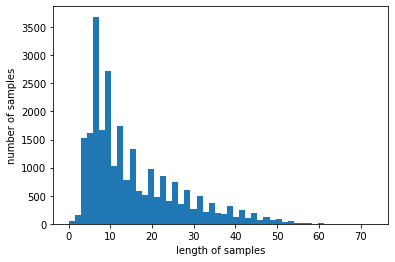

In [ ]:
#패딩 작업

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.95195964610272


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
# X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
# model.add(GRU(units=50, activation="relu", return_sequences=True, input_shape = (X_train.shape[1], 5)))
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(4, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         936500    
                                                                 
 gru_9 (GRU)                 (None, 128)               88320     
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,025,336
Trainable params: 1,025,336
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.9522 - acc: 0.6070
Epoch 1: val_acc improved from -inf to 0.64672, saving model to best_model.h5
313/313 [==============================] - 36s 107ms/step - loss: 0.9522 - acc: 0.6070 - val_loss: 0.8672 - val_acc: 0.6467
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.8098 - acc: 0.6577
Epoch 2: val_acc did not improve from 0.64672
313/313 [==============================] - 34s 108ms/step - loss: 0.8098 - acc: 0.6577 - val_loss: 0.8618 - val_acc: 0.6359
Epoch 3/15
312/313 [============================>.] - ETA: 0s - loss: 0.7503 - acc: 0.6850
Epoch 3: val_acc improved from 0.64672 to 0.66073, saving model to best_model.h5
313/313 [==============================] - 40s 129ms/step - loss: 0.7502 - acc: 0.6851 - val_loss: 0.8130 - val_acc: 0.6607
Epoch 4/15
312/313 [============================>.] - ETA: 0s - loss: 0.7000 - acc: 0.7107
Epoch 4: val_acc improved from 0.66073 to 0.66233, saving m

In [ ]:
loaded_model = load_model('best_model.h5')

In [ ]:
test_data.head()

,id,reviews
0,0,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요


In [ ]:
def score_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  scorebox=loaded_model.predict((pad_new))
  maxscore=max(list(scorebox[0]))
  scorelist=[1,2,4,5]
  # score = float(loaded_model.predict(pad_new))
  # star_score = int(score*100)//20+1
  for i in range(4):
    if scorebox[0][i]==maxscore:
      return scorelist[i]

In [ ]:
print(score_predict("아 정말 좋아요!!"))

5


In [ ]:
sentest= ["아진짜 좋아", "이거 대박", "정말 좋긴한데.. 뭔가 아쉬워요", "이거 진짜 진짜 너무 너무 별로다 ... 조상님이 울고가겠어요"]

for sen1 in sentest:
  print(sen1)
  print("다음 문장의 예측 별점은 {}점 입니다.".format(score_predict(sen1)))
  print()

아진짜 좋아
다음 문장의 예측 별점은 5점 입니다.

이거 대박
다음 문장의 예측 별점은 5점 입니다.

정말 좋긴한데.. 뭔가 아쉬워요
다음 문장의 예측 별점은 2점 입니다.

이거 진짜 진짜 너무 너무 별로다 ... 조상님이 울고가겠어요
다음 문장의 예측 별점은 2점 입니다.



In [ ]:
train_data.head()

,id,reviews,target,tokenized,label
0,0,조아요 처음구입 싸게햇어요,2,"[조아, 요, 처음, 구입, 싸, 햇, 어요]",0
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 천원가량 주고 사기 너무 아깝네요,1,"[생각, 보다, 잘, 안, 돼요, 매지, 바른, 하루, 밖에, 안, 됐, 는데, ㅠ...",0
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,"[디자인, 괜찮, 은데, 상품, 금, 서, 교환, 했, 는데, 두, 번, 째, 받,...",0
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 샘플...,2,"[기전, 제품, 말, 이마트, 트, 레이더스, 에서, 만, 팔, 던, 프리미엄, 제...",0
4,4,튼튼하고 손목을 잘 받쳐주네요,5,"[튼튼, 손목, 잘, 받쳐, 주, 네요]",1


In [ ]:
score_predict("생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 천원가량 주고 사기 너무 아깝네요")

1

In [ ]:
test_sen = test_data.reviews

pred = []

for sentence in test_sen:
  pred.append(score_predict(sentence))

In [ ]:
projectname = "shop"
model = "GRU"
testnum = "002"

submit["target"] = pred
submit.head() 
submit.to_csv("sub_{}_{}_model_{}.csv".format(testnum, projectname, model),index=False)

In [ ]:
submit.head()

,id,target
0,0,4
1,1,1
2,2,5
3,3,1
4,4,1


In [ ]:
submit.head()

,id,target
0,0,5
1,1,2
2,2,5
3,3,2
4,4,2
